In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import arviz as az
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform, downsample
from REStats.circular_metrics import circular_rmse, circular_mae, circular_mean, circular_residuals
from REStats.models import wind_speed, weibull, wind_dir
from REStats.plots import save_figs, plot_circular_histogram

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
sns.set_theme()

In [3]:
wt = load_SCADA(2019)

In [4]:
SAVE_FIGS = True
figs = {}

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

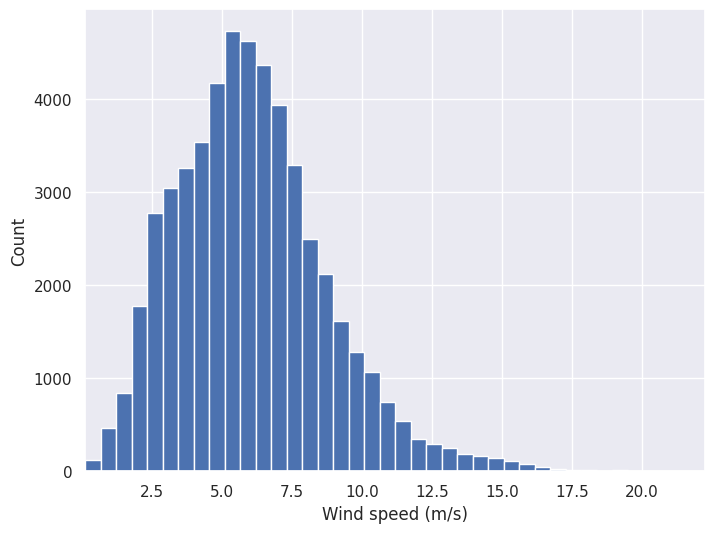

In [5]:
full_ws_hist, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Count")

b = ax.hist(wt.wind_speed, bins=40)

figs["full_ws_hist"] = full_ws_hist

In [6]:
wt_1m = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")]

wt_ds = downsample(wt_1m) 

ws = wt_ds[["wind_speed"]]

/home/cam/workspace/projects/REStats/REStats/utils.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["turbulence_intensity"] = (


In [7]:
wt_ds.isnull().sum()

wind_speed              0
wind_dir                0
power                   0
turbulence_intensity    0
dtype: int64

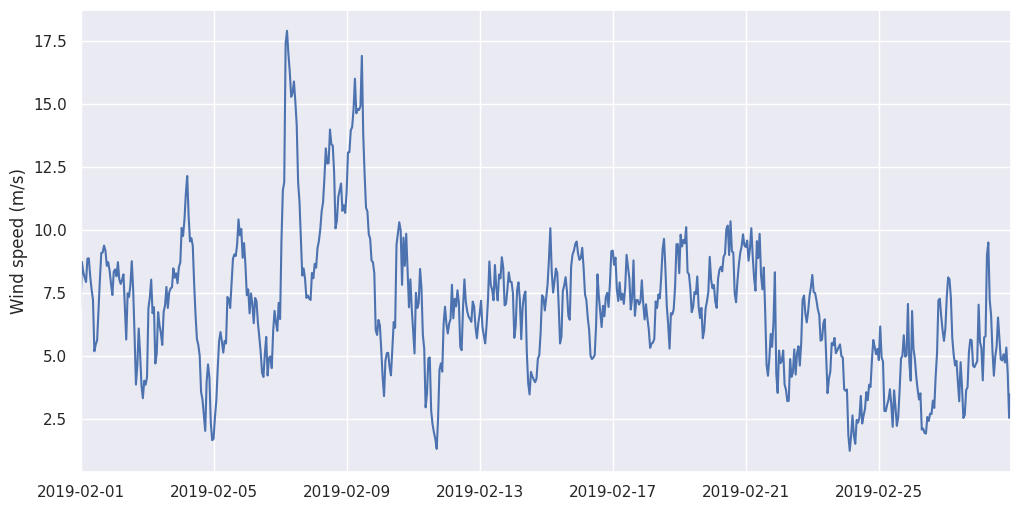

In [8]:
training_raw, ax = plt.subplots(figsize=(12, 6))

ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(wt_ds.index, wt_ds.wind_speed)

figs["training_raw"] = training_raw

## Modeling: Wind Speed Distribution

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [9]:
idata_wb = weibull.fit(wt_ds.wind_speed)

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:15, 97.58it/s, step size=6.29e-01, acc. prob=0
Sample [1]: 100%|█| 1500/1500 [00:14, 100.69it/s, step size=7.76e-01, acc. prob=


In [10]:
wt_ds.wind_speed.describe()

count    672.000000
mean       6.926740
std        2.713543
min        1.224047
25%        5.091319
50%        6.937040
75%        8.325460
max       17.903056
Name: wind_speed, dtype: float64

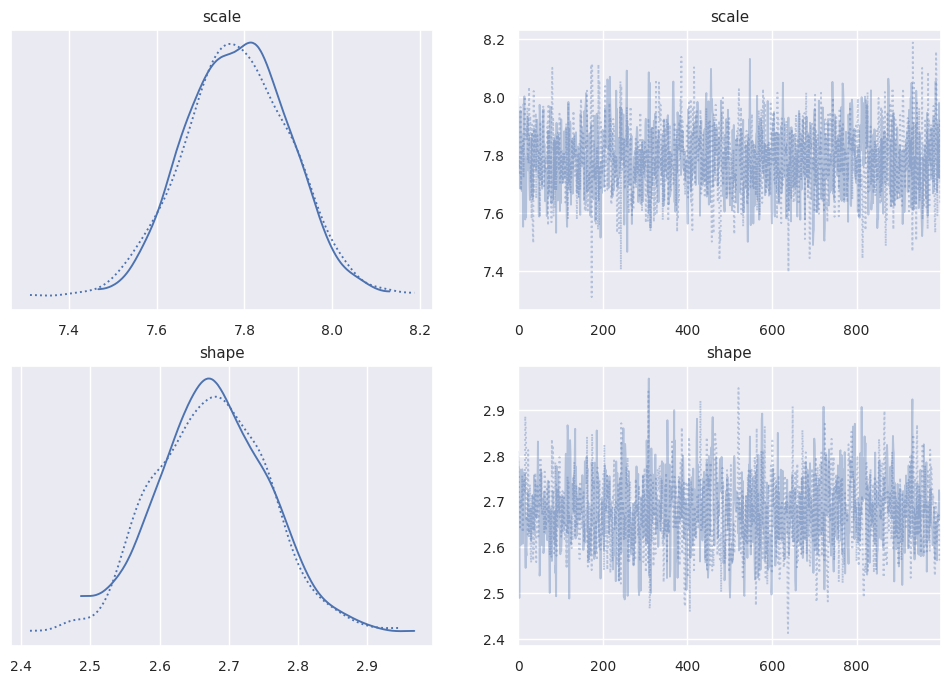

In [11]:
az.plot_trace(idata_wb, figsize=(12, 8))

wb_trace = plt.gcf()
figs["wb_trace"] = wb_trace

In [12]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 672 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1615.43    21.16
p_loo        2.81        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      672  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
idata_wb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

/home/cam/workspace/projects/REStats/REStats/models/weibull.py:110: RuntimeWarning: divide by zero encountered in power
  * (x / scale) ** (shape - 1)


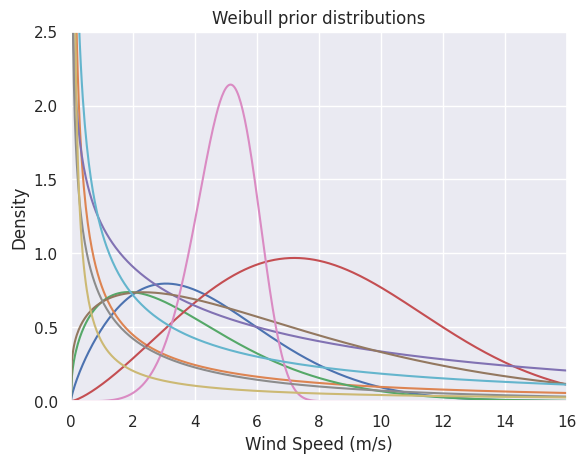

In [14]:
fig = weibull.plot_prior_samples(idata_wb)
    
figs["wb_prior"] = fig

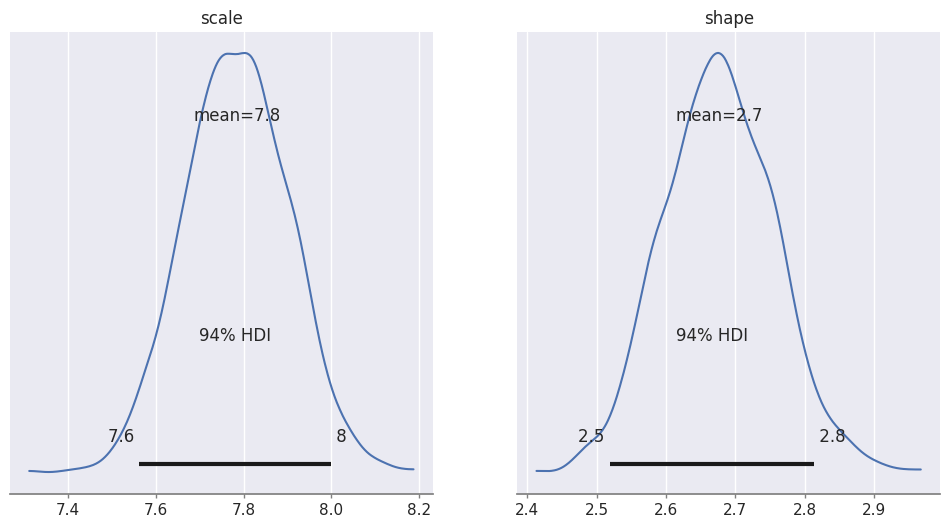

In [15]:
az.plot_posterior(idata_wb, figsize=(12, 6))

wb_posterior = plt.gcf()

figs["wb_posterior"] = wb_posterior

In [16]:
# wb_ppc, ax = plt.subplots(figsize=(8, 6))

# az.plot_ppc(idata_wb, ax=ax)
# ax.set_xlabel("Wind speed (m/s)")

# figs["wb_ppc"] = wb_ppc

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [17]:
shape = idata_wb.posterior.shape.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.scale.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.7435744723660934


In [18]:
ws_tf, hr_stats = transform(ws, m)

ws_tf.head()

,wind_speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2019-02-01 00:00:00,6.851252,4.182705,6.851252,0,-0.017728
2019-02-01 01:00:00,8.726291,5.006992,8.726291,1,0.667109
2019-02-01 02:00:00,8.323363,4.834045,8.323363,2,0.474792
2019-02-01 03:00:00,8.106309,4.739993,8.106309,3,0.336656
2019-02-01 04:00:00,7.925400,4.661108,7.925400,4,0.198725


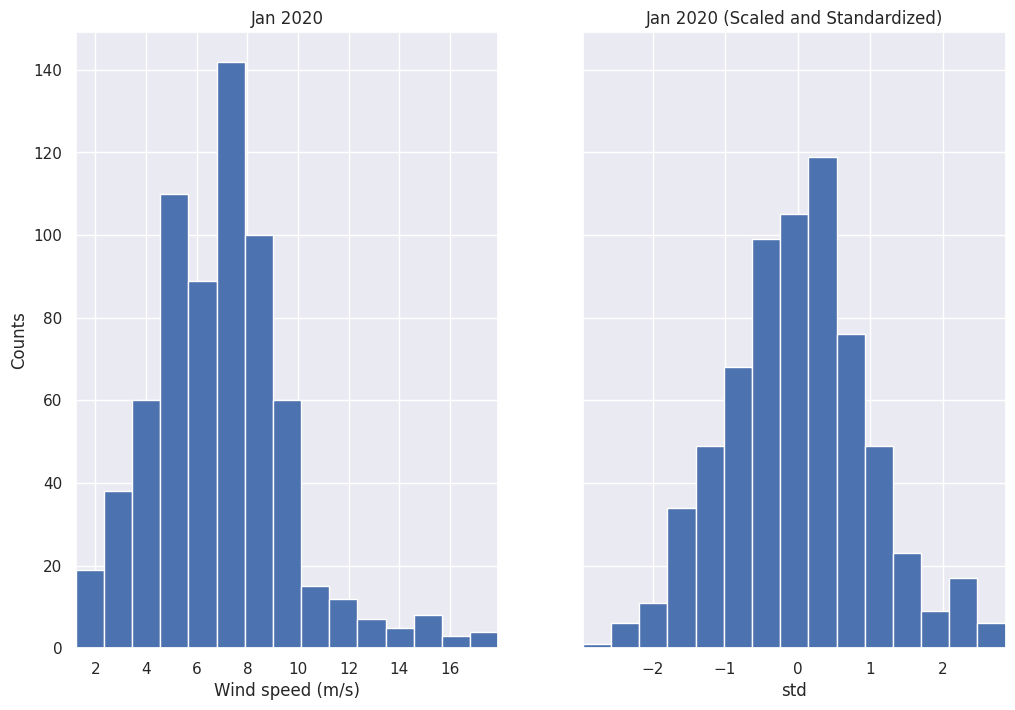

In [19]:
ws_hist_std_comparison, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(ws_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(ws_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

figs["ws_hist_std_comparison"] = ws_hist_std_comparison

## Modeling: Wind Speed

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

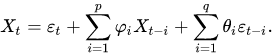

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


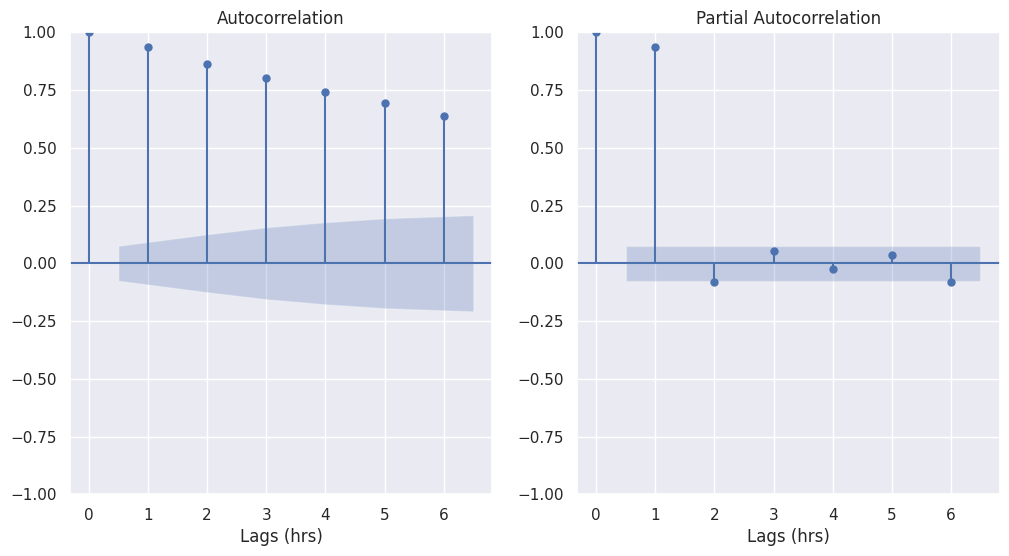

In [20]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_speed, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_speed, lags=6, ax=axes[1])

figs["acf_ws"] = autocorrelation

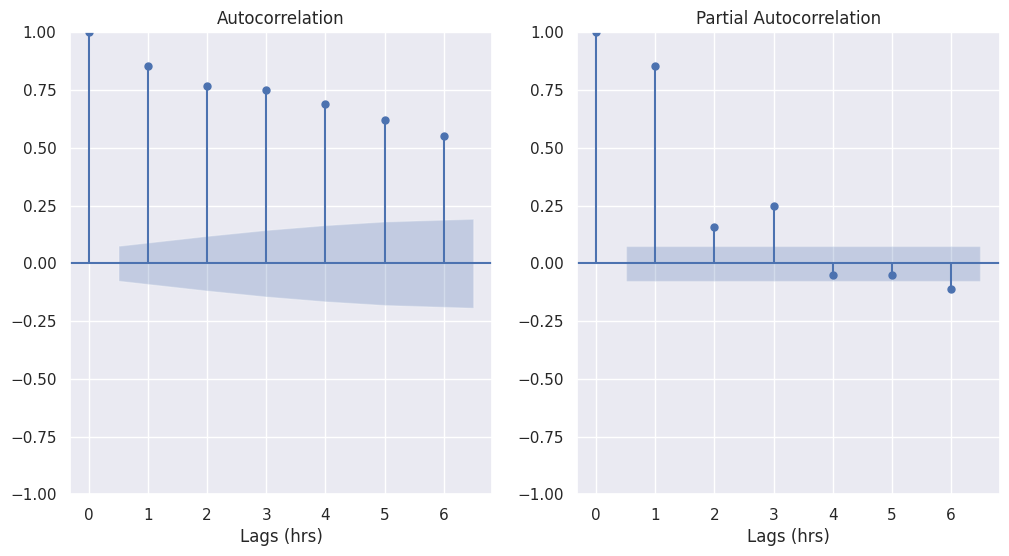

In [21]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_dir, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_dir, lags=6, ax=axes[1])

figs["acf_wind_dir"] = autocorrelation

In [22]:
# Forecast wind_dir using the persistence method
steps_ahead = 1
wind_dir_forecast = wind_dir.calc_persistence(wt_ds, steps_ahead)

# Calculate RMSE and MAE for the wind_dir persistence method predictions
wind_dir_rmse = circular_rmse(wt_ds["wind_dir"][steps_ahead:], wind_dir_forecast.dropna())
wind_dir_rmse_rel = wind_dir_rmse / circular_mean(wt_ds["wind_dir"][steps_ahead:]) * 100
wind_dir_mae = circular_mae(wt_ds["wind_dir"][steps_ahead:], wind_dir_forecast.dropna())

# Print the RMSE and MAE values
print(f"Wind direction RMSE: {wind_dir_rmse} deg")
print(f"Wind direction RMSE (%): {wind_dir_rmse_rel}")
print(f"Wind direction MAE: {wind_dir_mae} deg")

Wind direction RMSE: 12.979217756324138 deg
Wind direction RMSE (%): 6.071495871305177
Wind direction MAE: 8.061766490596876 deg


In [23]:
arma_mod = ARIMA(ws_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  672
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -272.592
Date:                Tue, 09 May 2023   AIC                            555.185
Time:                        17:35:23   BIC                            577.736
Sample:                    02-01-2019   HQIC                           563.919
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4980      0.270      1.843      0.065      -0.032       1.028
ar.L2          0.4085      0.245      1.667      0.095      -0.072       0.889
ma.L1          0.4614      0.271      1.705      0.0

In [24]:
pred = arma_res.get_prediction().summary_frame()
pred = pred.copy()
pred

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2019-02-01 00:00:00,0.000000,0.982943,-1.926533,1.926533
2019-02-01 01:00:00,-0.016463,0.364684,-0.731231,0.698304
2019-02-01 02:00:00,0.634930,0.364577,-0.079627,1.349488
2019-02-01 03:00:00,0.376852,0.363050,-0.334714,1.088418
2019-02-01 04:00:00,0.357003,0.362697,-0.353871,1.067876
...,...,...,...,...
2019-02-28 19:00:00,-0.615675,0.362470,-1.326103,0.094753
2019-02-28 20:00:00,-1.104093,0.362470,-1.814521,-0.393665
2019-02-28 21:00:00,-0.804068,0.362470,-1.514496,-0.093639


Reverse the transformations for error calculations and plotting.

In [25]:
inv_pred = inv_transform(pred, m, hr_stats)
arma_rmse = mean_squared_error(ws_tf.v, inv_pred["mean"], squared=False)
arma_rmse_rel = arma_rmse/ws_tf.v.mean()*100

arma_mae = mean_absolute_error(ws_tf.v, inv_pred["mean"])

print(f"ARMA(2, 2) RMSE: {arma_rmse} m/s")
print(f"ARMA(2, 2) RMSE (%): {arma_rmse_rel}")
print(f"ARMA(2, 2) MAE: {arma_mae} m/s")

ARMA(2, 2) RMSE: 0.9223885960837572 m/s
ARMA(2, 2) RMSE (%): 13.316345783048355
ARMA(2, 2) MAE: 0.7127459315253759 m/s


In [26]:
per = ws_tf.v.shift(1).bfill()
per_rmse = mean_squared_error(ws_tf.v, per, squared=False)
per_rmse_rel = per_rmse/ws_tf.v.mean()*100
per_mae = mean_absolute_error(ws_tf.v, per)

print(f"PER RMSE: {per_rmse} m/s", per_rmse)
print(f"PER RMSE (%): {per_rmse_rel}")
print(f"PER MAE: {per_mae} m/s")

PER RMSE: 0.9755607840147397 m/s 0.9755607840147397
PER RMSE (%): 14.083982377360604
PER MAE: 0.7487402425714988 m/s


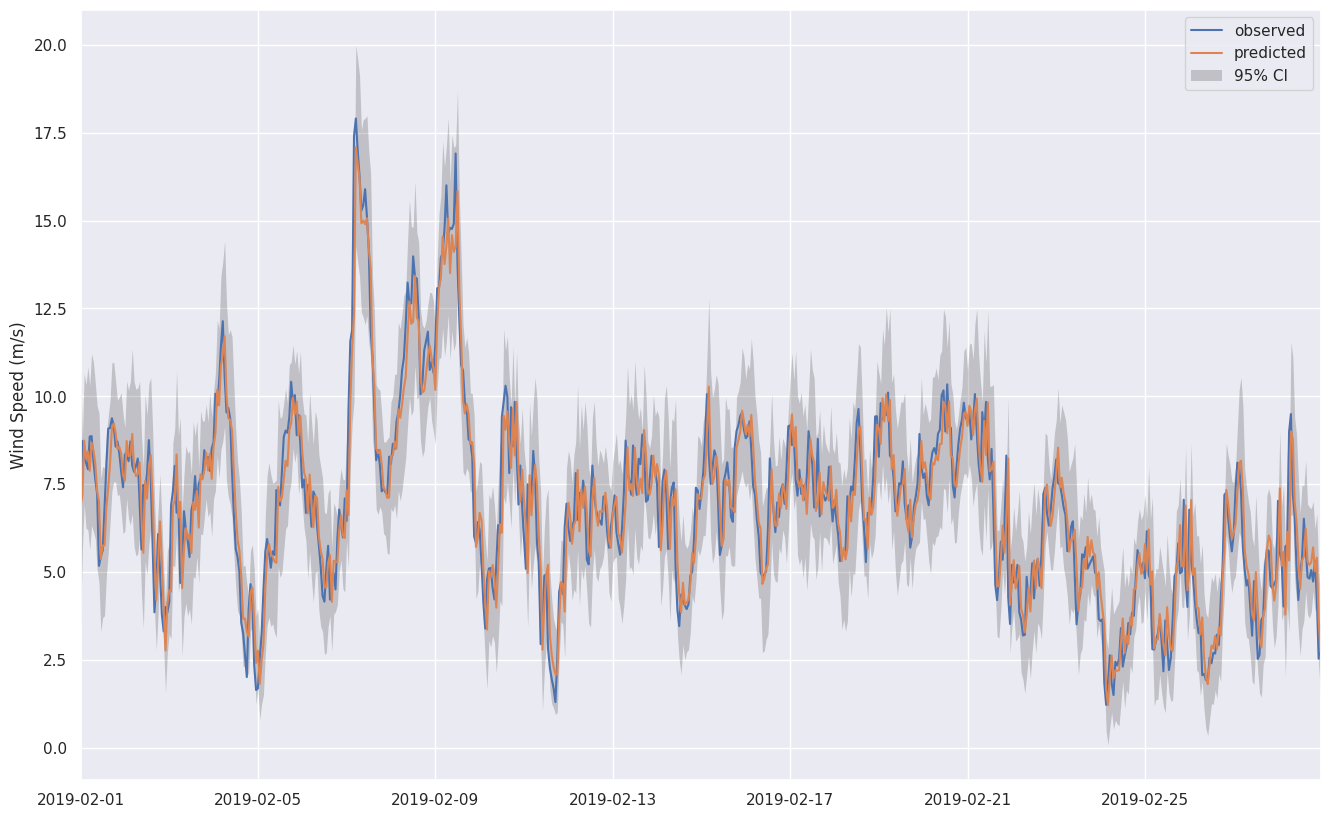

In [27]:
arma_fit_results, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(ws_tf.index, ws_tf.v, label="observed")

ax.plot(inv_pred.index, inv_pred["mean"], label="predicted")
ax.fill_between(
    inv_pred.index, 
    inv_pred.mean_ci_lower, 
    inv_pred.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()

figs["arma_fit_results"] = arma_fit_results

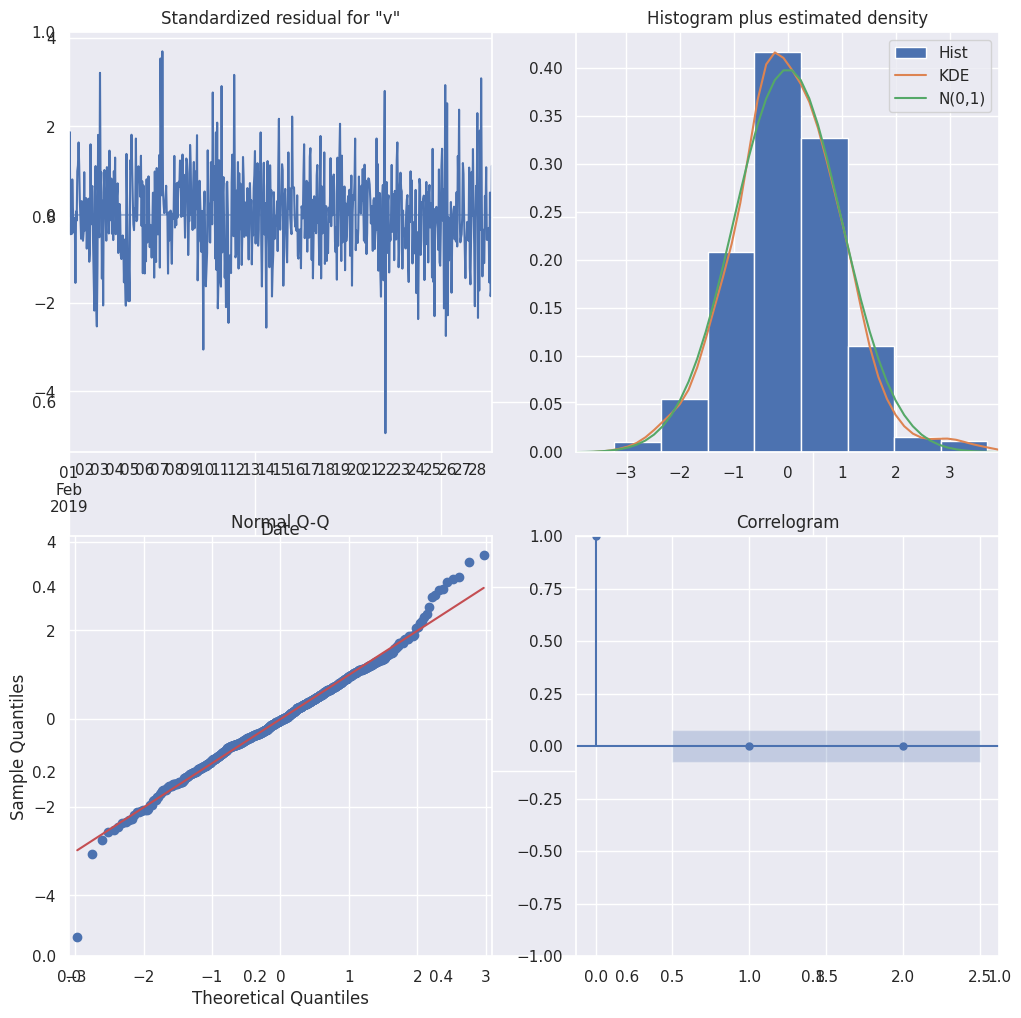

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

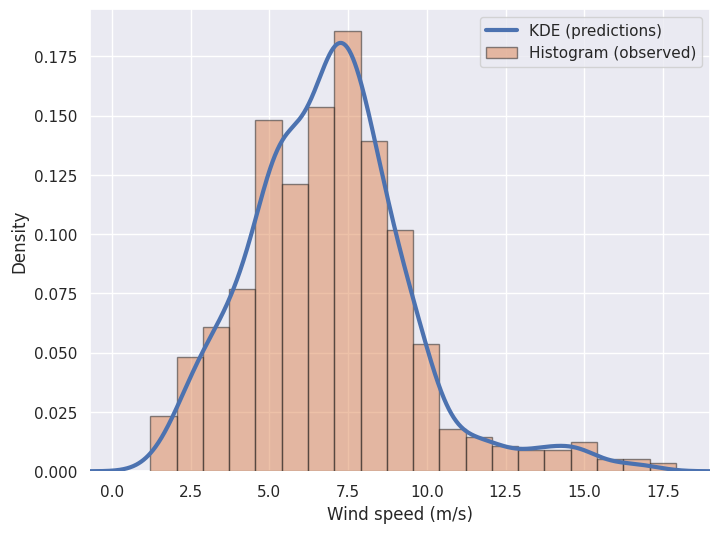

In [29]:
kde = sm.nonparametric.KDEUnivariate(inv_pred["mean"])
kde.fit()  # Estimate the densities

arma_fit_kde, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    ws_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

figs["arma_fit_kde"] = arma_fit_kde

## Forecast: Wind Speed

In [30]:
wt_train = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")].copy()
wt_test = wt[(wt.index >= "2019-03-01") & (wt.index < "2019-04-01")].copy()

v_train = wt_train[["wind_speed"]].resample("H").mean()
assert v_train["wind_speed"].isnull().sum() == 0 # sanity check
v_test = wt_test[["wind_speed"]].resample("H").mean()
assert v_test["wind_speed"].isnull().sum() == 0 # sanity check

In [31]:
forecasts_full, _ = wind_speed.backtest(v_train, v_test, idata_wb=idata_wb)


Results for step size: 1
Forecast RMSE: 1.1152155671534552 m/s
Forecast RMSE (%): 14.639095951235207
Forecast MAE: 0.8308856248918228 m/s


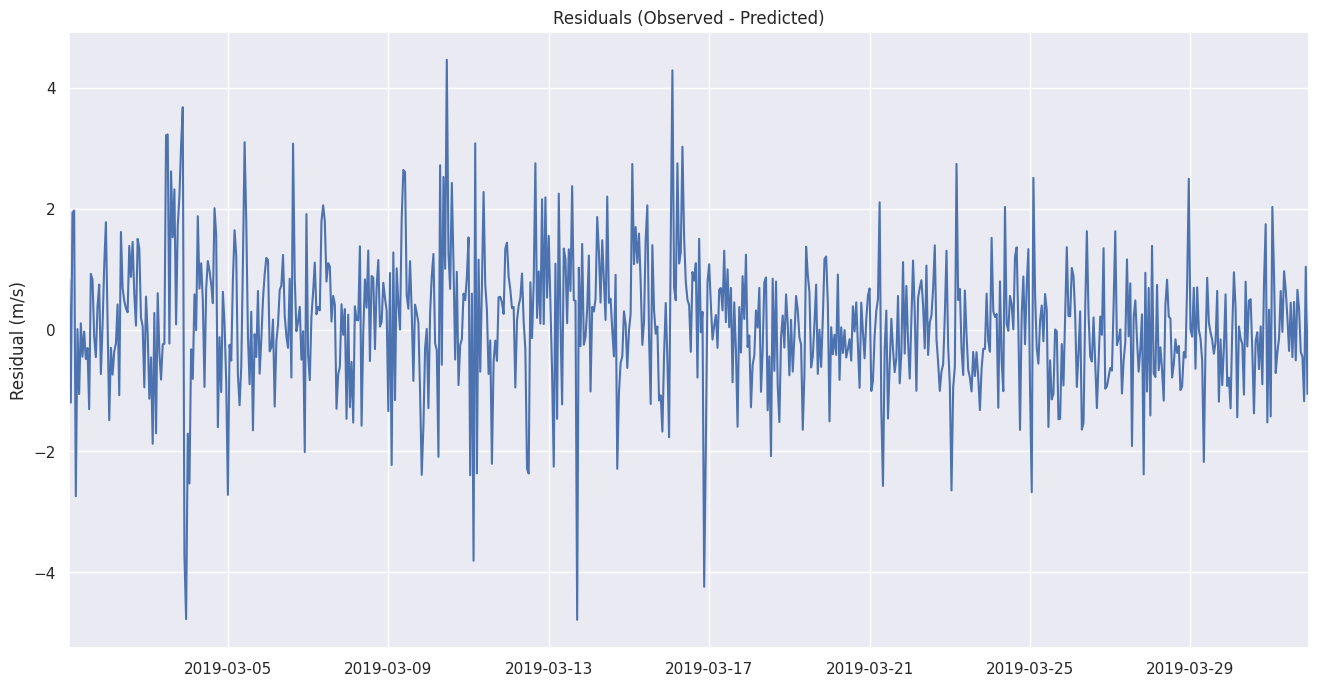

In [32]:
arma_forecast_resid, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Residual (m/s)")
ax.set_xmargin(0)
ax.set_title("Residuals (Observed - Predicted)")

resid = v_test["wind_speed"][1:] - forecasts_full["mean"]

ax.plot(forecasts_full.index, resid)

figs["arma_forecast_resid"] = arma_forecast_resid

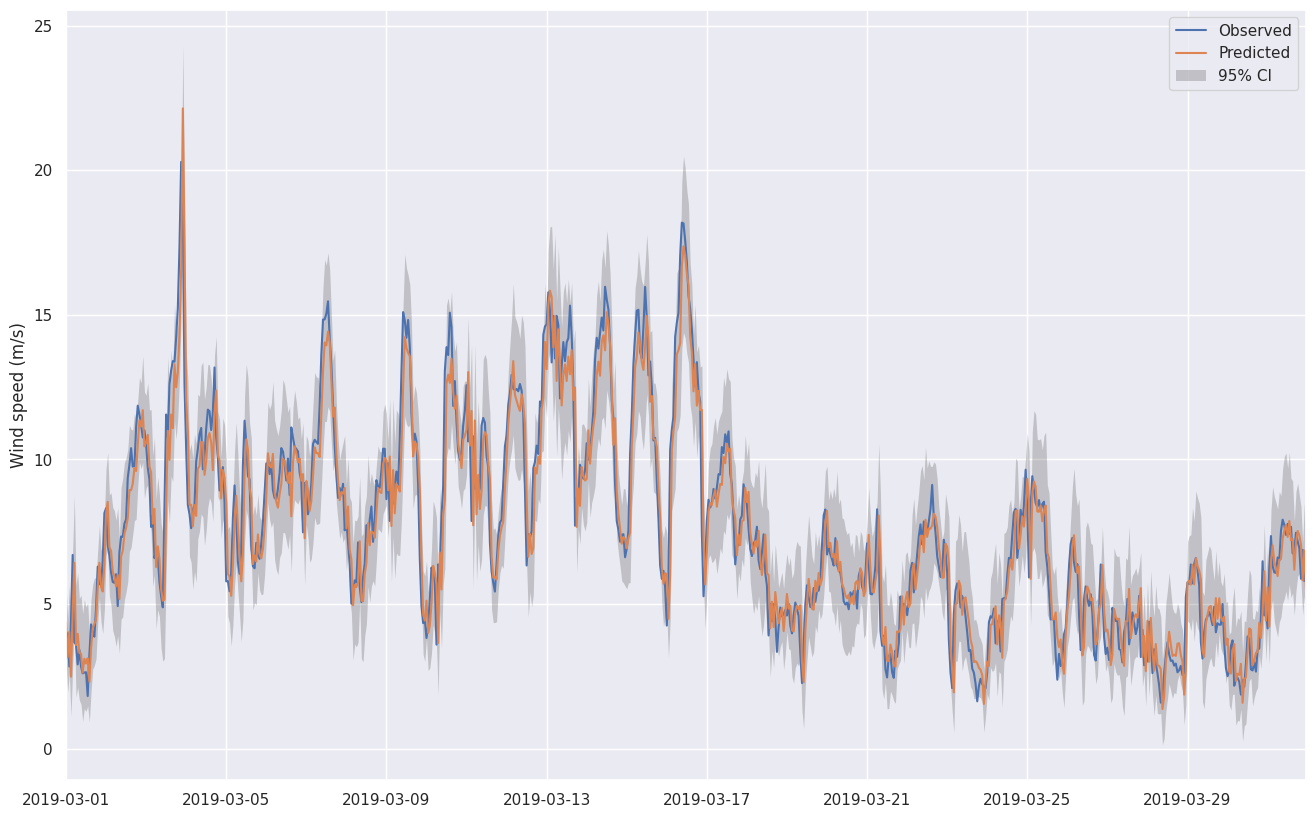

In [33]:
arma_forecast_results, ax = plt.subplots(figsize=(16, 10))
ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(v_test.index[1:], v_test[1:], label="Observed")
ax.plot(forecasts_full.index, forecasts_full["mean"], label="Predicted")


ax.fill_between(
    forecasts_full.index, 
    forecasts_full.mean_ci_lower, 
    forecasts_full.mean_ci_upper,
    color="k", alpha=.2, linewidth=0, label="95% CI"
)

ax.legend()

figs["arma_forecast_results"] = arma_forecast_results

In [34]:
dtype = np.dtype([("rmse", float), ("rmse_rel", float), ("mae", float)])

err_fcast = np.empty(6, dtype=dtype)
err_per = np.empty(6, dtype=dtype)

for i in range(6):
    _, err_f = wind_speed.backtest(v_train, v_test, idata_wb=idata_wb, steps=i+1)
    err_fcast[i] = err_f
    _, err_p = wind_speed.calc_persistence(v_test["wind_speed"], steps=i+1)
    err_per[i] = err_p


Results for step size: 1
Forecast RMSE: 1.1152155671534552 m/s
Forecast RMSE (%): 14.639095951235207
Forecast MAE: 0.8308856248918228 m/s
PER RMSE: 1.0665964958934706 m/s
PER RMSE (%): 13.989717228624315
PER MAE: 0.787914913415891 m/s

Results for step size: 2
Forecast RMSE: 1.4185972747306863 m/s
Forecast RMSE (%): 18.6214954602456
Forecast MAE: 1.052449998706612 m/s
PER RMSE: 1.3816011094520115 m/s
PER RMSE (%): 18.12138790855144
PER MAE: 0.9730507319423822 m/s

Results for step size: 3
Forecast RMSE: 1.5820922999541749 m/s
Forecast RMSE (%): 20.76764498710827
Forecast MAE: 1.171719255229421 m/s
PER RMSE: 1.6915336750507197 m/s
PER RMSE (%): 22.186532477619142
PER MAE: 1.202846780339593 m/s

Results for step size: 4
Forecast RMSE: 1.802775430320905 m/s
Forecast RMSE (%): 23.66448539662972
Forecast MAE: 1.327675547705621 m/s
PER RMSE: 1.799082114985078 m/s
PER RMSE (%): 23.59716177262822
PER MAE: 1.294294889753988 m/s

Results for step size: 5
Forecast RMSE: 2.098345187248369 m/s
For

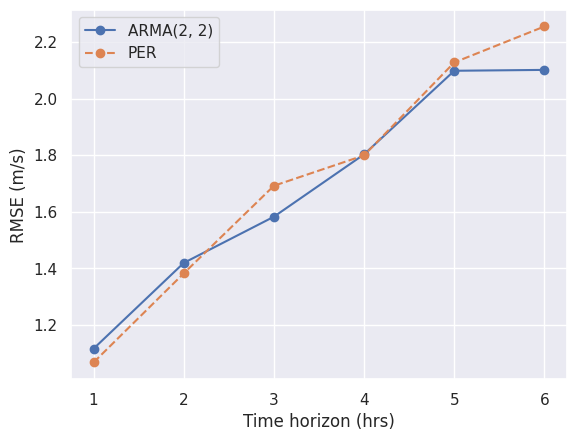

In [35]:
fig, ax = plt.subplots()
# ax.set_xmargin(0)

ax.set_xlabel("Time horizon (hrs)")
ax.set_ylabel("RMSE (m/s)")
ax.plot(range(1, len(err_fcast) + 1), [e[0] for e in err_fcast], marker="o", label="ARMA(2, 2)")
ax.plot(range(1, len(err_per) + 1), [e[0] for e in err_per], linestyle="--", marker="o", label="PER")
ax.legend()

figs["ws_arma_per"] = fig

## Modeling: Wind Direction

In [36]:
# Load your wind direction data as a 1D array (e.g., a numpy array or a pandas Series)
wind_dir_data = wt_ds.wind_dir.values

sin_model, cos_model = wind_dir.fit(wind_dir_data)
res = wind_dir.predict(sin_model, cos_model, wind_dir_data)
res

,wind_dir_pred,wind_dir_obs,lower_bound,upper_bound
0,215.455009,62.316973,298.574371,158.468371
1,62.309702,52.220494,35.696701,83.184759
2,49.239907,47.412911,24.827685,71.951375
3,46.577506,53.989870,22.332515,69.881148
4,56.208787,50.168086,30.561070,77.797084
...,...,...,...,...
667,269.957398,286.072572,282.583773,247.104045
668,290.398866,300.330975,297.183439,275.493672
669,302.155611,308.103162,305.571231,293.960965
670,307.997938,322.534348,309.698375,303.785428


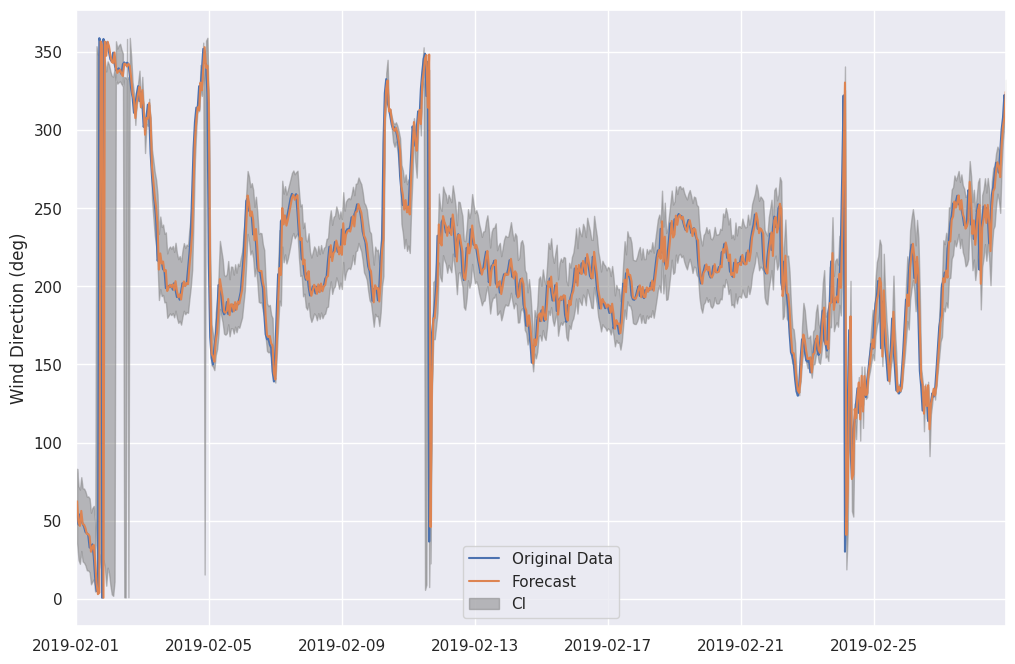

In [37]:
# Plot the forecasts and CI intervals
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_ylabel("Wind Direction (deg)")
ax.plot(wt_ds.index, wind_dir_data, label="Original Data")
ax.plot(wt_ds.index[1:],
         res.wind_dir_pred[1:], label="Forecast")
ax.fill_between(wt_ds.index[1:],
                 res.lower_bound[1:], res.upper_bound[1:], color="gray", alpha=0.5, label="CI")
ax.legend()

figs["wd_pred"] = fig

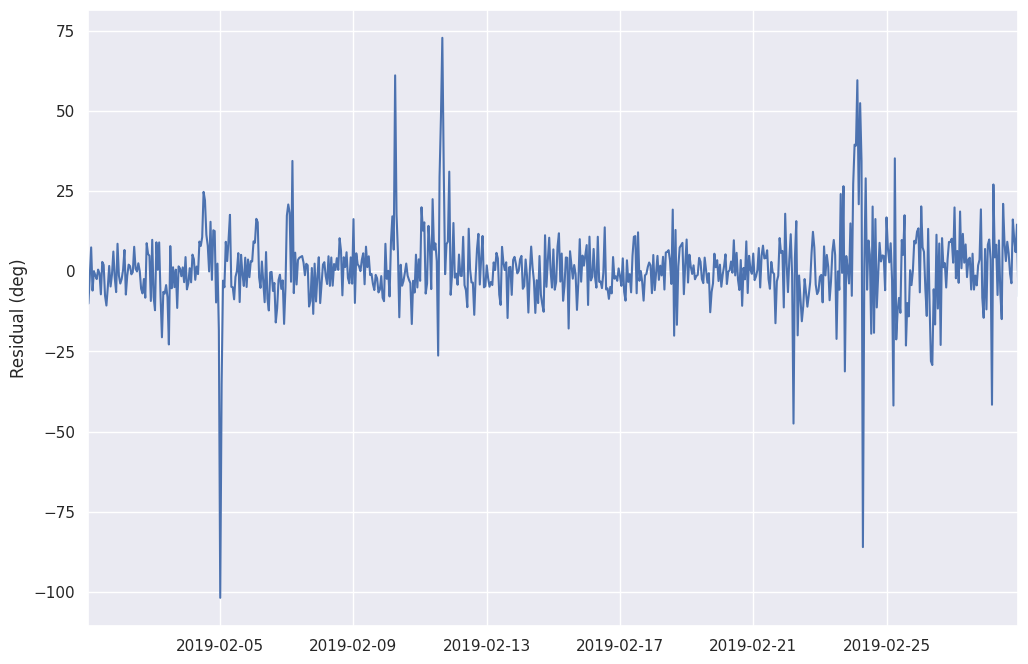

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xmargin(0)
ax.set_ylabel("Residual (deg)")

ax.plot(wt_ds.index[1:], circular_residuals(res.wind_dir_obs, res.wind_dir_pred)[1:])

figs["wd_resid"] = fig

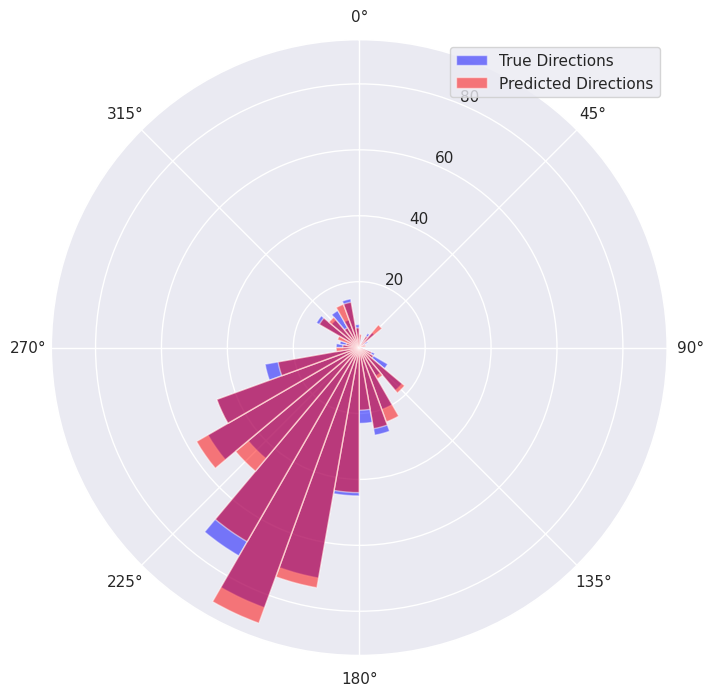

In [39]:
fig = plot_circular_histogram(res.wind_dir_obs, res.wind_dir_pred)

figs["dir_fcast_hist"] = fig

## Forecast: Wind Direction

In [40]:
if SAVE_FIGS:
    save_figs(figs)